<a href="https://colab.research.google.com/github/JazzPauw/capstone/blob/main/People_Statistics_Traffic_Control_in_a_Mall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [1]:
from google.colab import drive
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2
from scipy.optimize import curve_fit


drive.mount('/content/drive')
root = '/content/drive/My Drive/frames/'

# Load annotations and create DataFrame
gt = loadmat(f'{root}mall_gt.mat')
df = pd.DataFrame({
    'head_count': gt['count'].flatten(),
    'annotations': [frame_df[0][0][0] for frame_df in gt['frame'][0]]})
df['head_count'] = df['head_count'].astype(int)

df = df.reset_index()
df = df.rename({'index': 'frame_id'}, axis=1)
df.frame_id = df.index + 1

df['image_name'] = df['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')

# Load perspective map
pMap = loadmat(f'{root}perspective_roi.mat')['pMapN']

df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,frame_id,head_count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


In [2]:
df.head_count.describe()

,head_count
count,2000.000000
mean,31.157500
std,6.945417
min,13.000000
25%,26.000000
50%,31.000000
75%,36.000000
max,53.000000


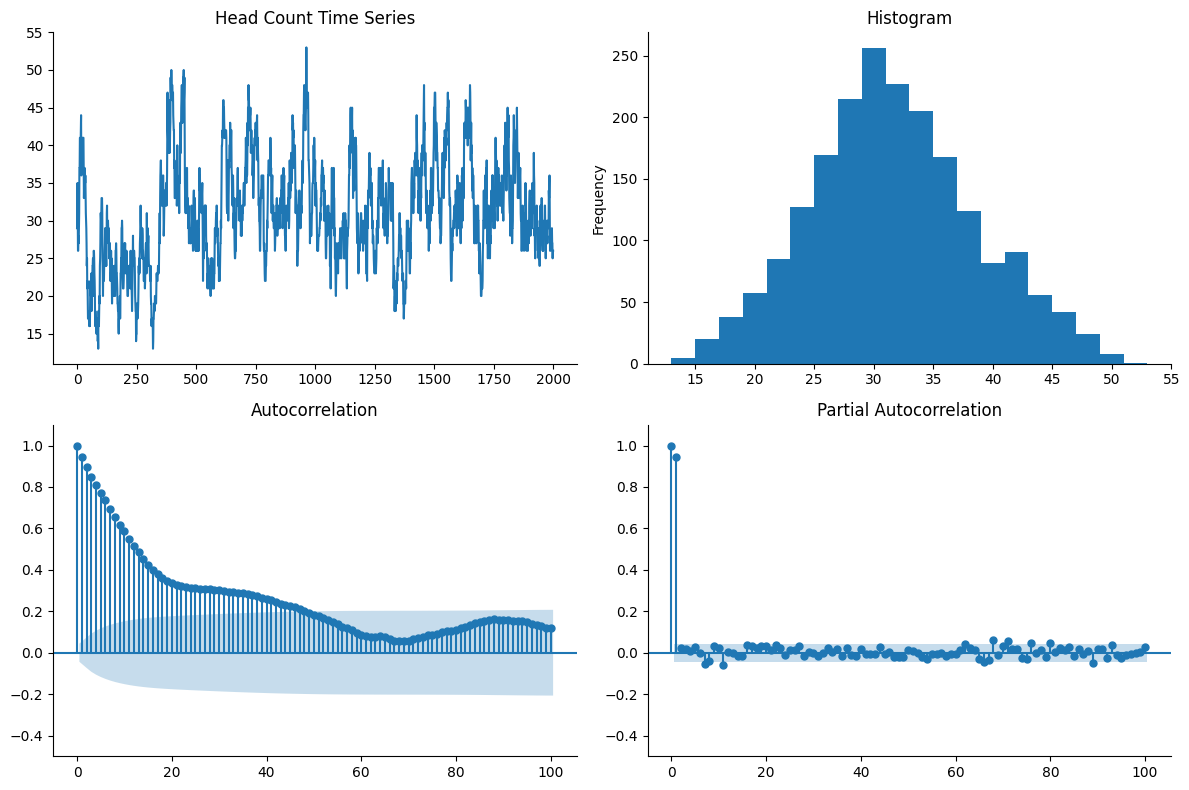

In [3]:
import statsmodels.api
import statsmodels as sm

def tsplot(y, title, lags=100, bins = 20, figsize=(12, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.'''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins = bins)
    hist_ax.set_title('Histogram')
    sm.graphics.tsaplots.plot_acf (y, lags=lags, ax=acf_ax)
    sm.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_ylim(-0.5,1.1) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax


tsplot(df.head_count, "Head Count Time Series");

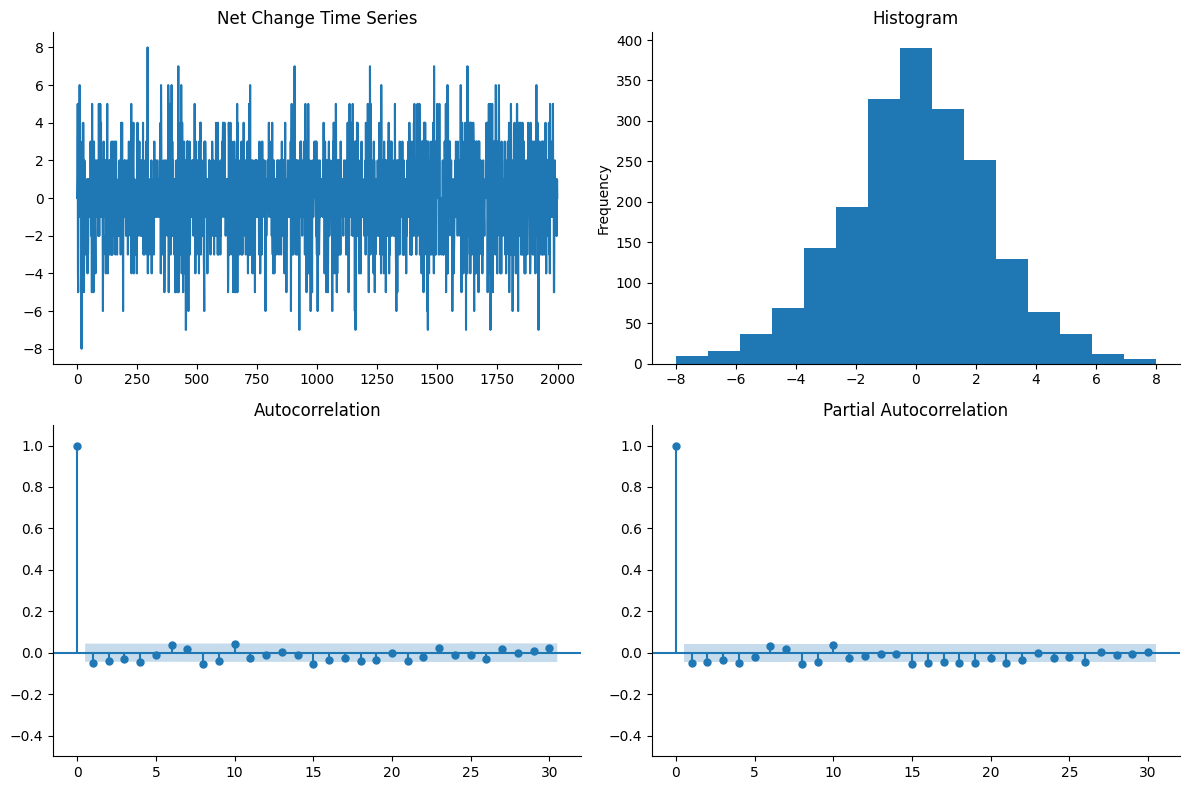

In [4]:
df['net_change'] = df['head_count'].diff().fillna(0)  # Compute the difference between consecutive frames

tsplot(df['net_change'],'Net Change Time Series',lags = 30, bins = 15);

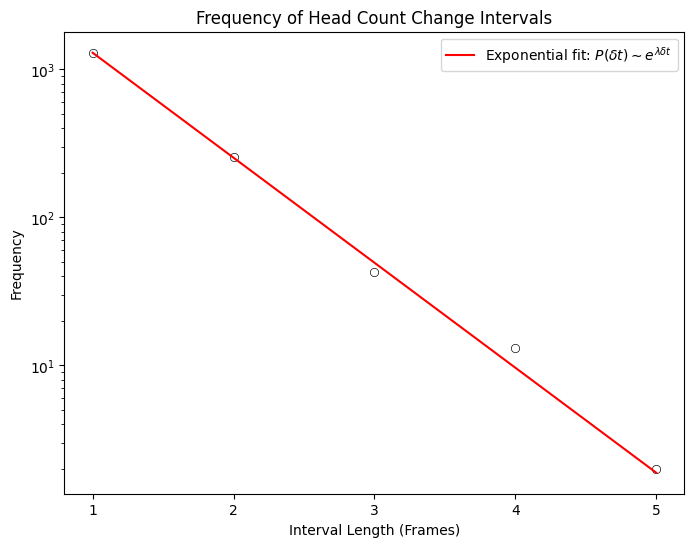

In [5]:
# Detect changes in head_count
df['change'] = df['net_change'] != 0

# Identify the frame indices where changes occur
change_indices = df[df['change']].index

# Calculate intervals between changes
intervals = change_indices[1:] - change_indices[:-1]
intervals = np.array(intervals)

# Calculate frequencies of each interval
interval_counts = pd.Series(intervals).value_counts().reset_index()
interval_counts.columns = ['interval', 'frequency']

# Exponential fit function
def exponential_fit(x, a, b):
    return a * np.exp(b * x)

pars, cov = curve_fit(f=exponential_fit, xdata=interval_counts['interval'], ydata=interval_counts['frequency'], p0=[0, 0])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=interval_counts, x='interval', y='frequency', edgecolor='black', color='white')
plt.plot(interval_counts['interval'], exponential_fit(interval_counts['interval'], *pars), color='red', label=f'Exponential fit: $P(\\delta t) \\sim e^{{\\lambda \\delta t}}$')

# Set y-axis to log scale
plt.yscale('log')
plt.xticks(range(1, interval_counts['interval'].max() + 1, 1))

# Adding title and labels
plt.title('Frequency of Head Count Change Intervals')
plt.xlabel('Interval Length (Frames)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

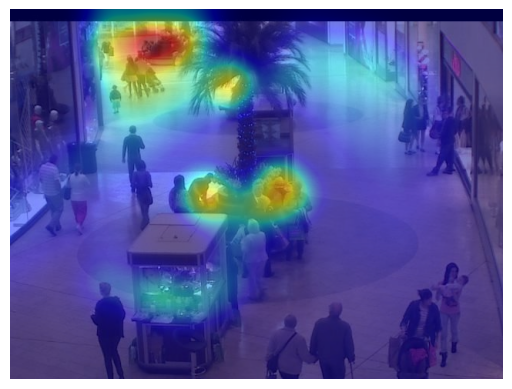

In [9]:
# Function to create a density map
def create_density_map(image_shape, head_locations, sigma=20):
    density_map = np.zeros(image_shape[:2])
    for x, y in head_locations:
        density_map[int(y)-1, int(x)-1] += 1
    return gaussian_filter(density_map, sigma=sigma)

# Image dimensions
height, width = 480, 640
frame_id = 1

# Aggregate all head locations from the dataset
all_head_locations = [point for idx, row in df.iterrows() for point in row['annotations']]

# Create the density map
density_map = create_density_map((height, width), all_head_locations)

# Apply logarithmic scaling to the density map
# Adding 1 before log to avoid log(0)
log_density_map = np.log(density_map + 1)

# Normalize the log-scaled density map for overlaying
density_map_normalized = log_density_map / np.max(log_density_map)
heatmap = plt.cm.jet(density_map_normalized)  # Apply a colormap where high values are red and low are blue

# Convert heatmap to RGB and ensure it is in uint8
heatmap_rgb = (heatmap[..., :3] * 255).astype(np.uint8)

# Load a frame and ensure it is in the right format and scale
background_path = f'{root}frames/' + df.image_name.iloc[frame_id]
background = cv2.imread(background_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
if background.dtype != np.uint8:
    background = (background * 255).astype(np.uint8)

# Overlay the heatmap on the first frame
overlayed_image = cv2.addWeighted(background, 0.5, heatmap_rgb, 0.5, 0)

# Plot the overlayed image
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

Annotation counts within each ROI: [4, 1, 4, 0, 4]


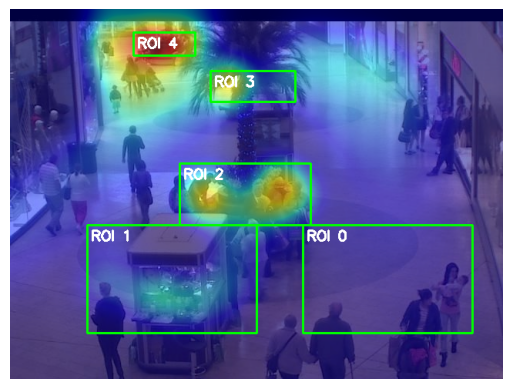

In [10]:
rois = [
    (380, 280, 600, 420), # ROI 0
    (100, 280, 320, 420),  # ROI 1
    (220, 200, 390, 280),  # ROI 2
    (260, 80, 370, 120), # ROI 3
    (160, 30, 240, 60)  # ROI 4
]

# Function to draw ROI boxes
def draw_roi_boxes(image, rois, color=(0, 255, 0), thickness=2, text_color=(255, 255, 255)):
    for i, roi in enumerate(rois):
        # Draw the rectangle for the ROI
        cv2.rectangle(image, (roi[0], roi[1]), (roi[2], roi[3]), color, thickness)
        # Prepare the label text for the ROI
        label = f'ROI {i}'
        # Calculate the position for the text (slightly above the rectangle)
        label_position = (roi[0]+5, roi[1]+20)
        # Add the label text to the image
        cv2.putText(image, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)

# Function to count heads within ROIs
def count_heads_in_rois(head_locations, rois):
    counts = [0] * len(rois)
    for x, y in head_locations:
        for i, roi in enumerate(rois):
            if roi[0] <= x <= roi[2] and roi[1] <= y <= roi[3]:
                counts[i] += 1
    return counts

# Draw ROI boxes on the frame
draw_roi_boxes(overlayed_image, rois)
current_head_locations = df.iloc[frame_id - 1]['annotations']
roi_counts = count_heads_in_rois(current_head_locations, rois)
print("Annotation counts within each ROI:", roi_counts)

# Display the frame with ROI boxes
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

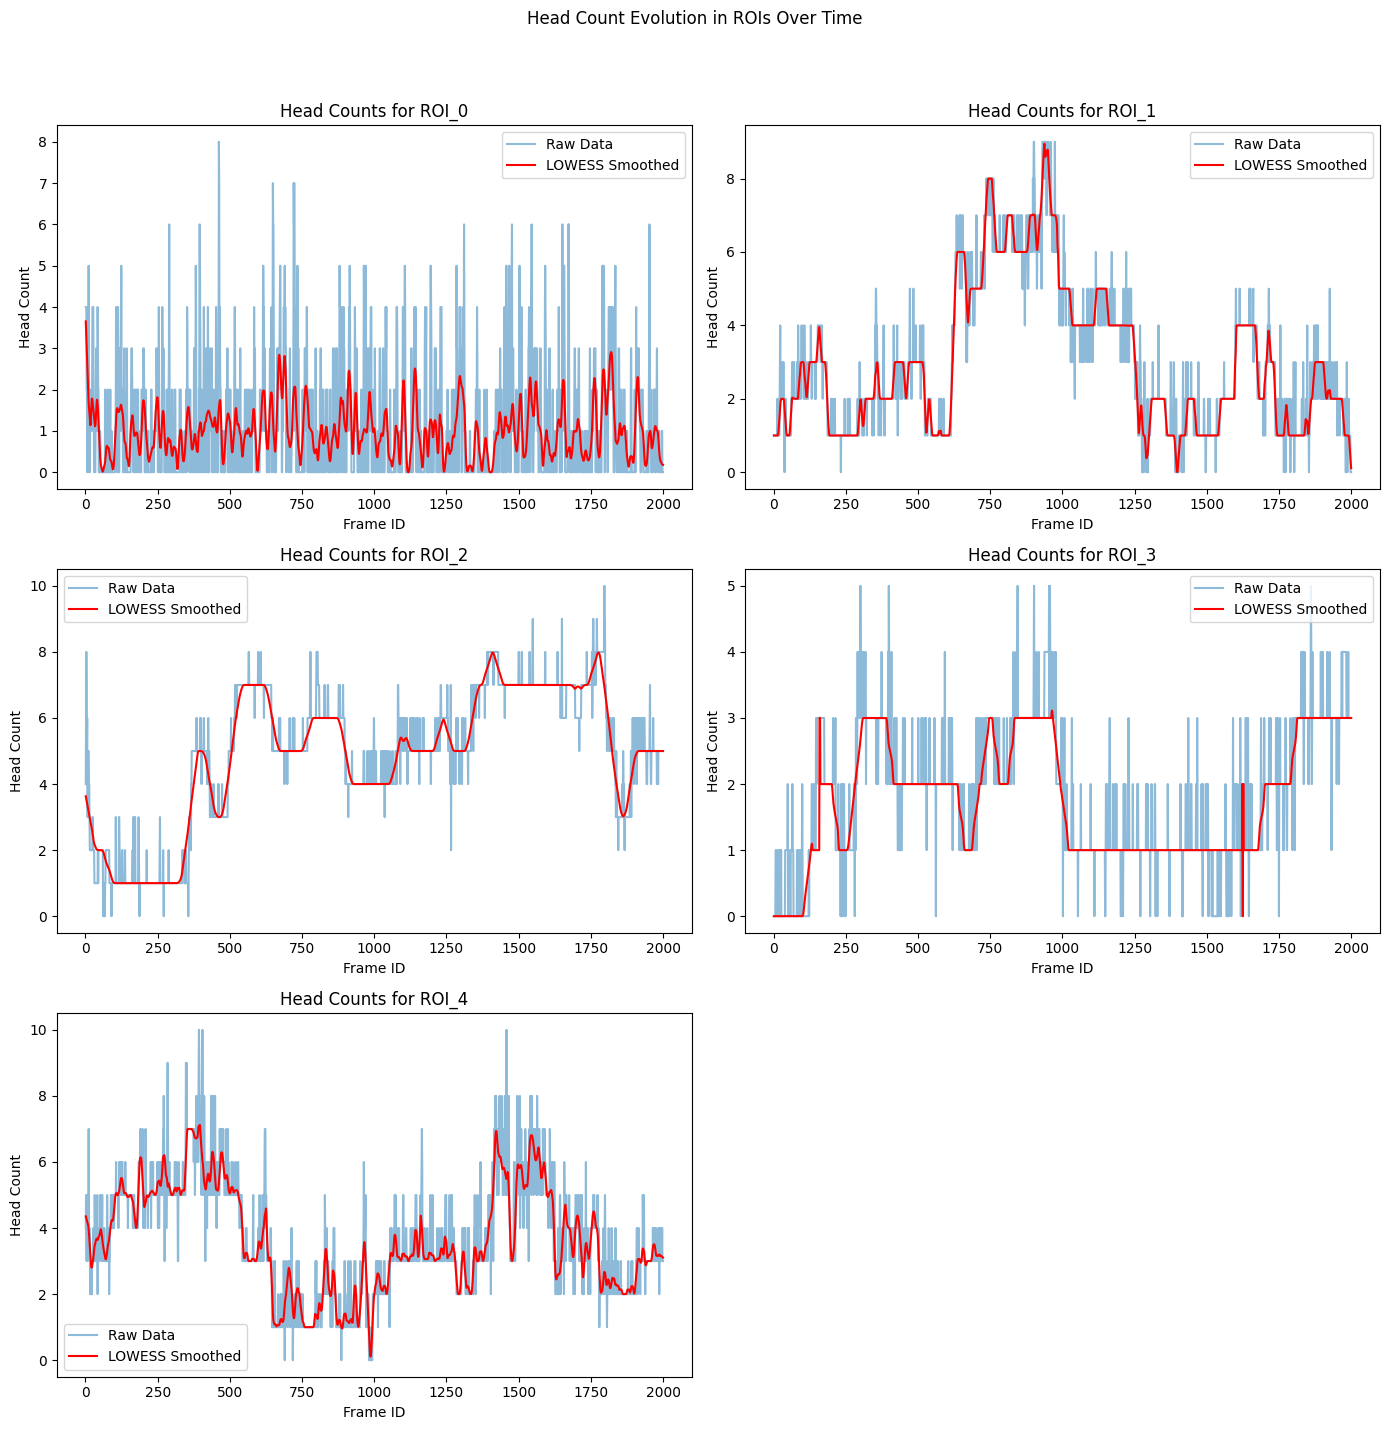

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Initialize a DataFrame to hold the time series data for each ROI
roi_time_series = pd.DataFrame(columns=['frame_id', 'roi_0', 'roi_1', 'roi_2', 'roi_3', 'roi_4'])

# Initialize a list to store the time series data for each ROI
roi_time_series_data = []

# Iterate over each row in df to process annotations for each frame
for _, row in df.iterrows():
    frame_id = row['frame_id']
    head_locations = row['annotations']

    # Count heads in each ROI
    counts = count_heads_in_rois(head_locations, rois)

    # Collect data for this frame
    roi_time_series_data.append([frame_id] + counts)

# Convert list to DataFrame
roi_time_series = pd.DataFrame(roi_time_series_data, columns=['frame_id', 'roi_0', 'roi_1', 'roi_2', 'roi_3', 'roi_4'])

# Setup the subplot grid based on the number of ROIs
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle('Head Count Evolution in ROIs Over Time')

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Define a list of optimized coefficient for LOWESS smoothing visualization
lowess_frac = [0.01, 0.008, 0.03, 0.03, 0.008]

# Loop through each ROI and apply LOWESS smoothing, then plot
for i in range(5):
    roi = f'roi_{i}'
    # Applying LOWESS smoothing
    smoothed = lowess(roi_time_series[roi], roi_time_series['frame_id'], frac=lowess_frac[i])

    # Using seaborn for plotting the raw data
    sns.lineplot(x=roi_time_series['frame_id'], y=roi_time_series[roi], label='Raw Data', alpha=0.5, ax=axs[i])
    # Plotting LOWESS smoothed data directly with matplotlib to avoid seaborn's smoothing
    axs[i].plot(smoothed[:, 0], smoothed[:, 1], label='LOWESS Smoothed', color='red')

    axs[i].set_title(f'Head Counts for {roi.upper()}')
    axs[i].set_xlabel('Frame ID')
    axs[i].set_ylabel('Head Count')
    axs[i].legend()

# Hide the last (unused) subplot
axs[-1].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

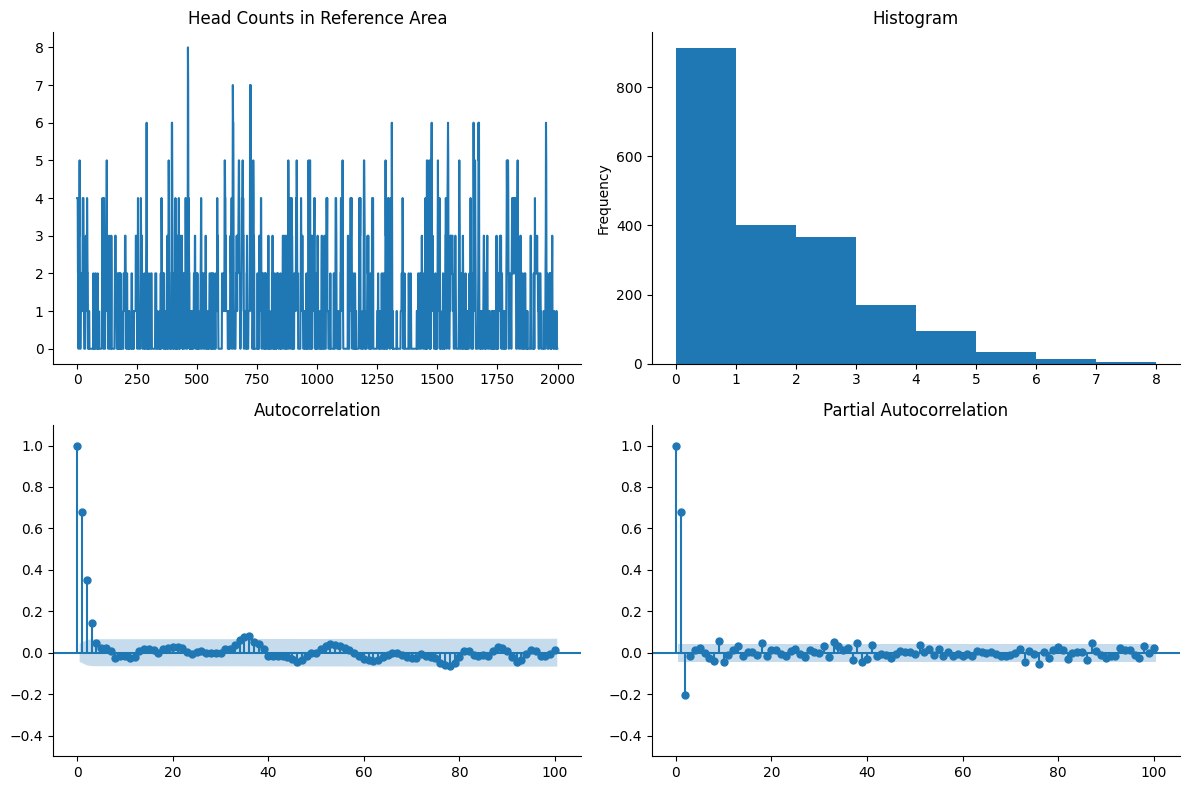

In [12]:
tsplot(roi_time_series['roi_0'],'Head Counts in Reference Area', lags = 100, bins = 8);

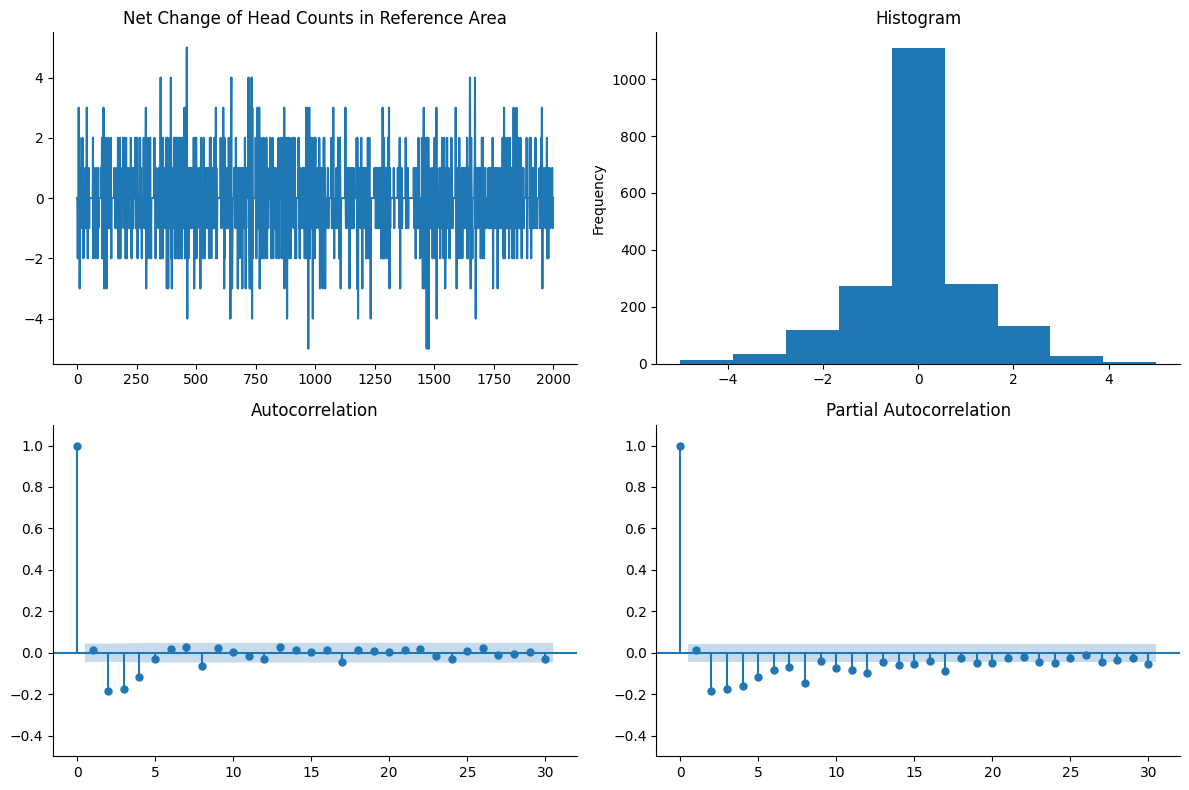

In [13]:
tsplot(roi_time_series['roi_0'].diff().fillna(0),'Net Change of Head Counts in Reference Area', bins = 9, lags = 30);

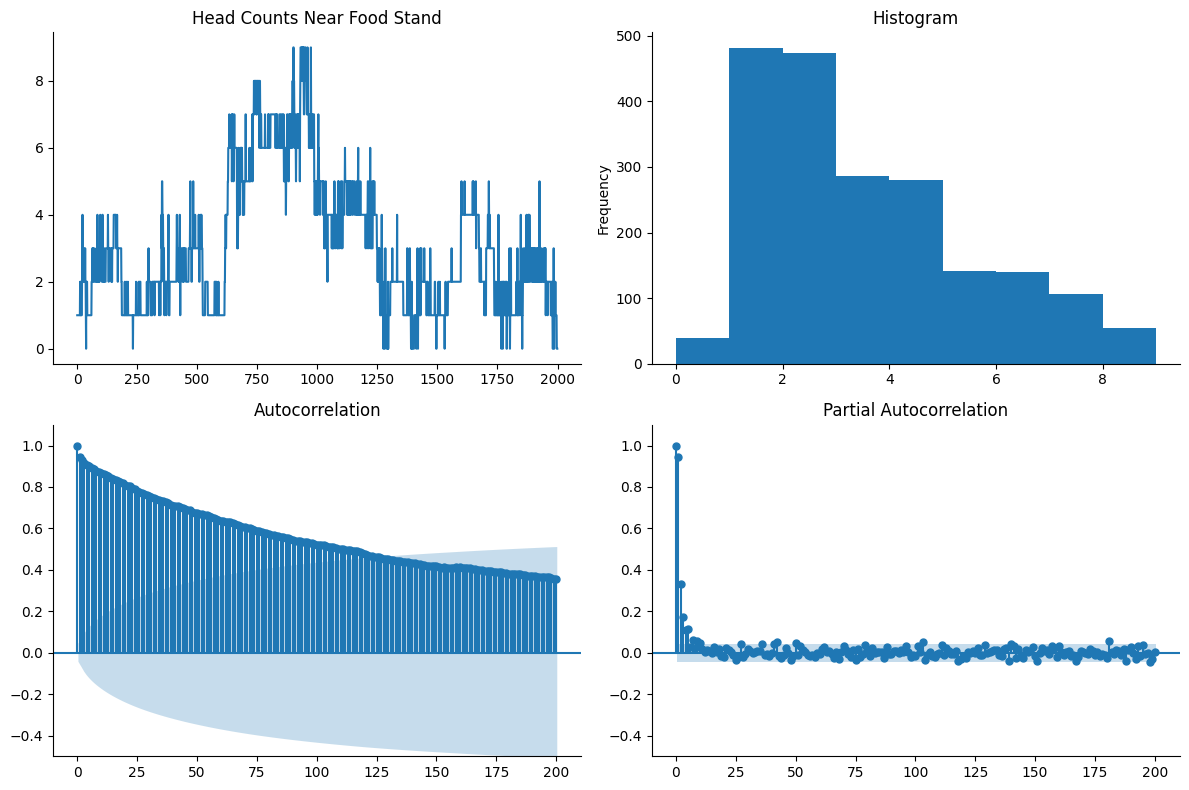

In [14]:
tsplot(roi_time_series['roi_1'],'Head Counts Near Food Stand', lags = 200, bins = 9);

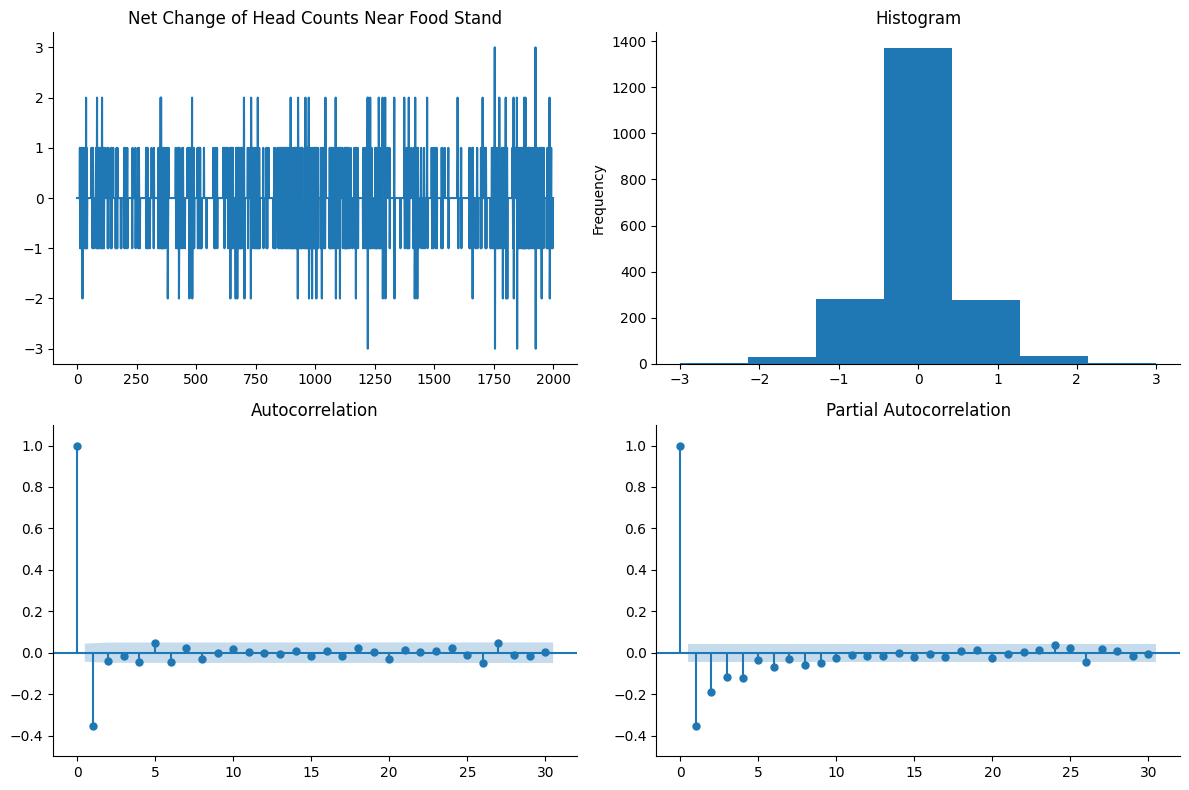

In [15]:
tsplot(roi_time_series['roi_1'].diff().fillna(0),'Net Change of Head Counts Near Food Stand', lags = 30, bins = 7);

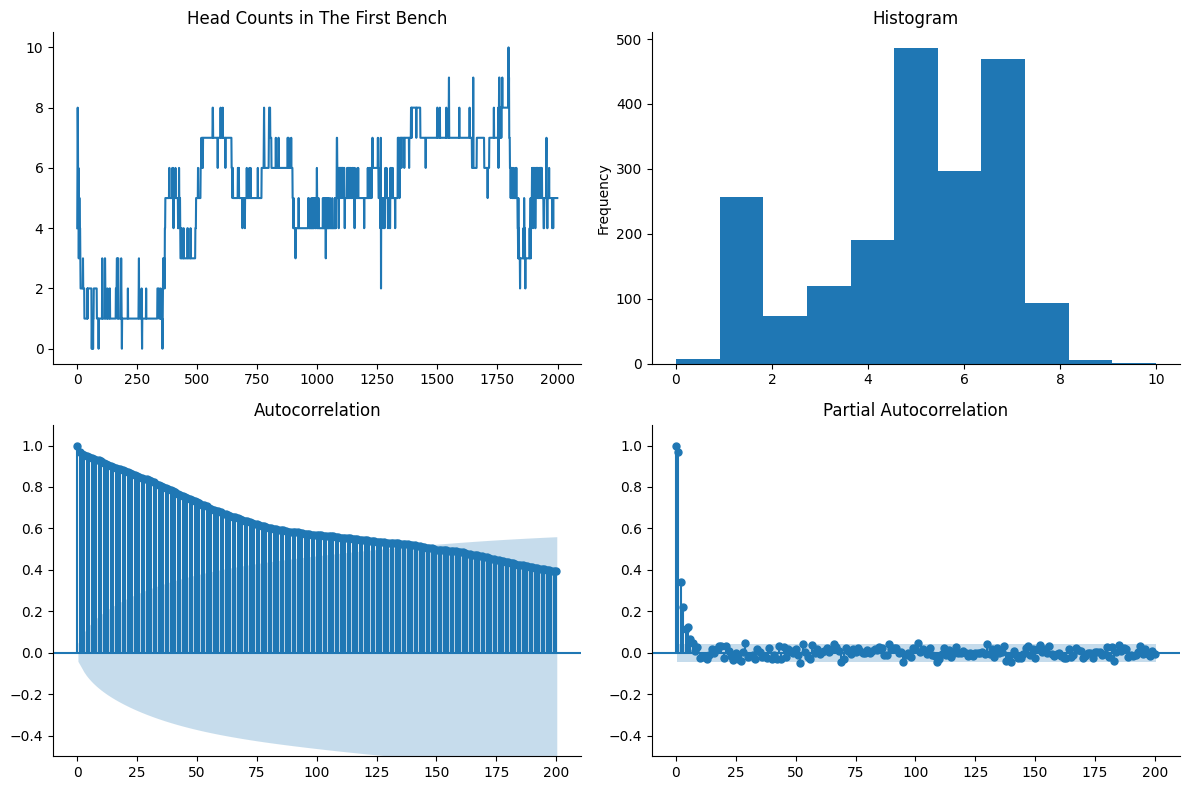

In [16]:
tsplot(roi_time_series['roi_2'],'Head Counts in The First Bench', lags = 200, bins = 11);

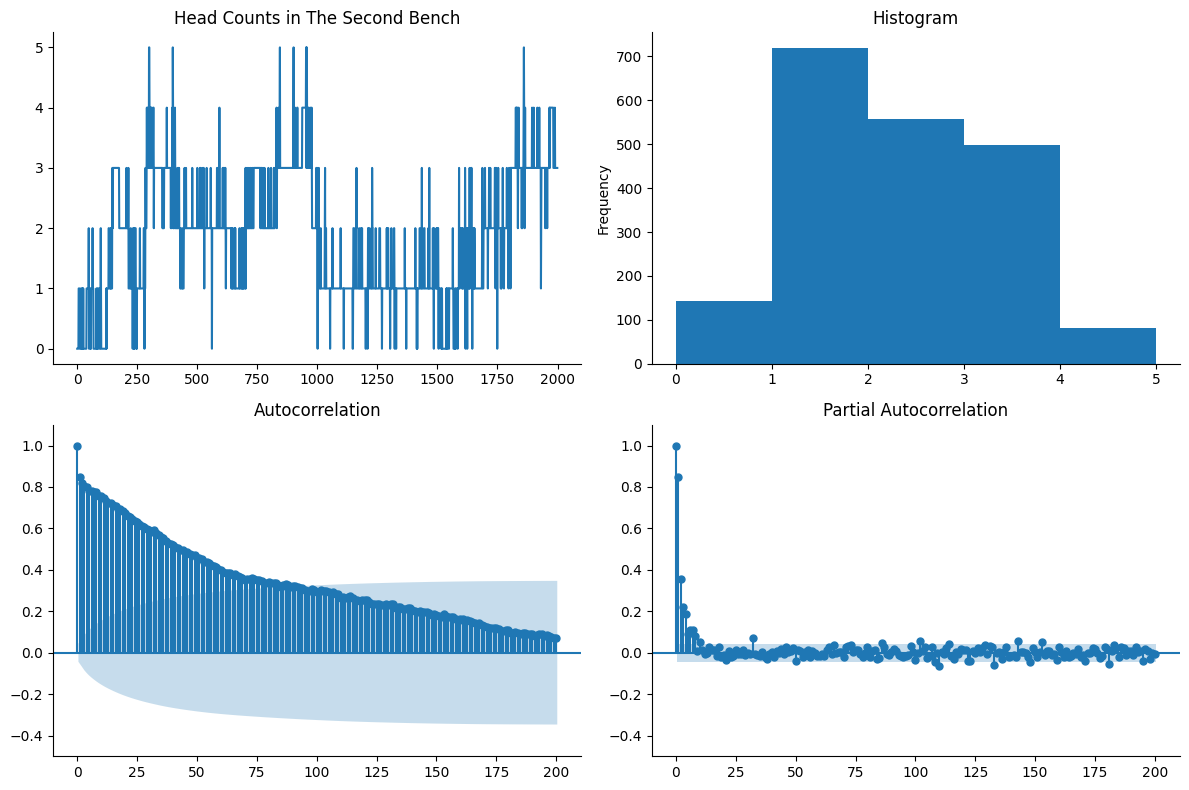

In [17]:
tsplot(roi_time_series['roi_3'],'Head Counts in The Second Bench', lags = 200, bins = 5);

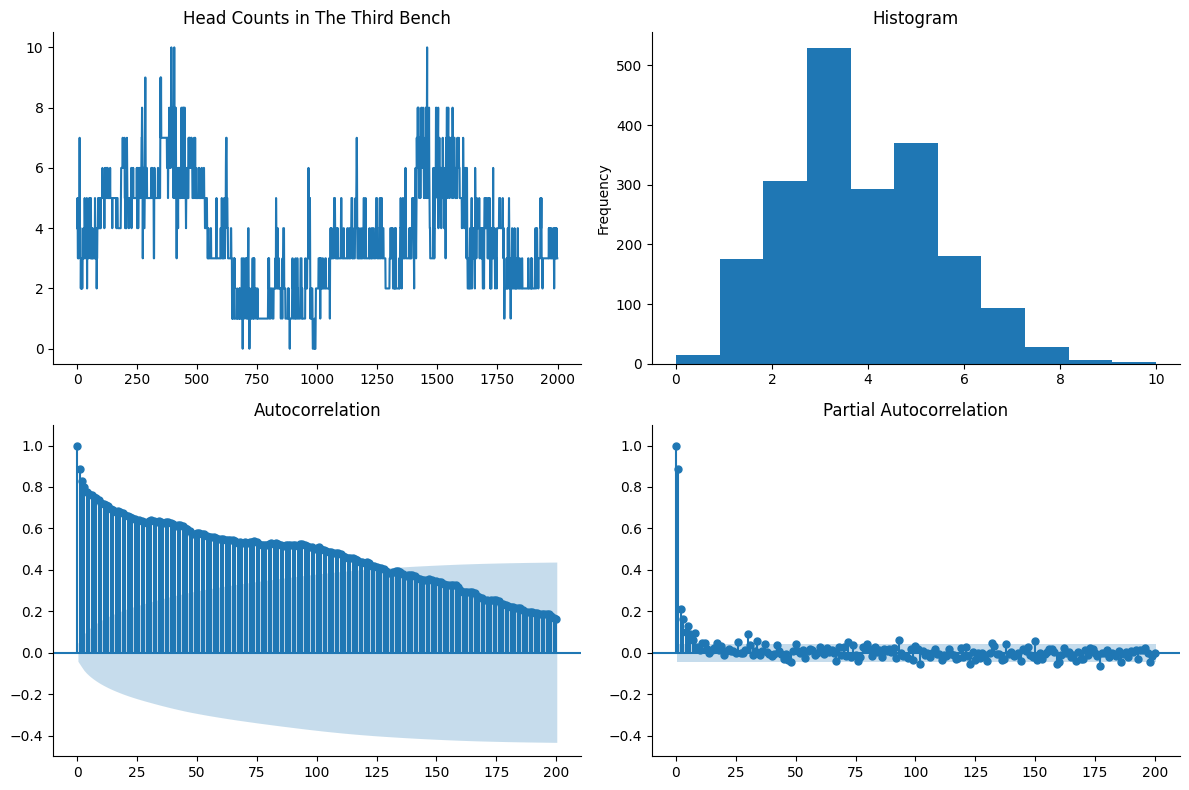

In [18]:
tsplot(roi_time_series['roi_4'],'Head Counts in The Third Bench', lags = 200, bins = 11);